In [1]:
import uproot
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import awkward as ak
import os

In [2]:
# Directory path containing the ROOT files
directory_path = '/eos/purdue/store/user/lingqian/fullrun2_eft_minitrees/spinCorrInput_2016preVFP/Nominal'

# Define the specific files you want to include (with subdirectories)
desired_files = [
    'ee/ee_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'ee/ee_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root',
    
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_0to700_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_700to900_2016preVFP.root',
    'mumu/mumu_ttto2l2nu_jet_smeft_mtt_900toInf_2016preVFP.root'
]

# Construct the full paths for the desired files
file_paths = [os.path.join(directory_path, filename) for filename in desired_files]

# Open each ROOT file and extract the 'ttBar_treeVariables_step8' TTree
trees = [uproot.open(file_path)['ttBar_treeVariables_step8'] for file_path in file_paths]

# Concatenate the TTrees from all files into a single TTree
file = uproot.concatenate(trees)

In [5]:
file_simple=file[0:500000]
mg_weight=file_simple['mgWeights']

In [6]:
#Obtain the structure constant
import EFT_event_weights_calcu
SC_reco= EFT_event_weights_calcu.obtain_structure_constant(16, mg_weight)



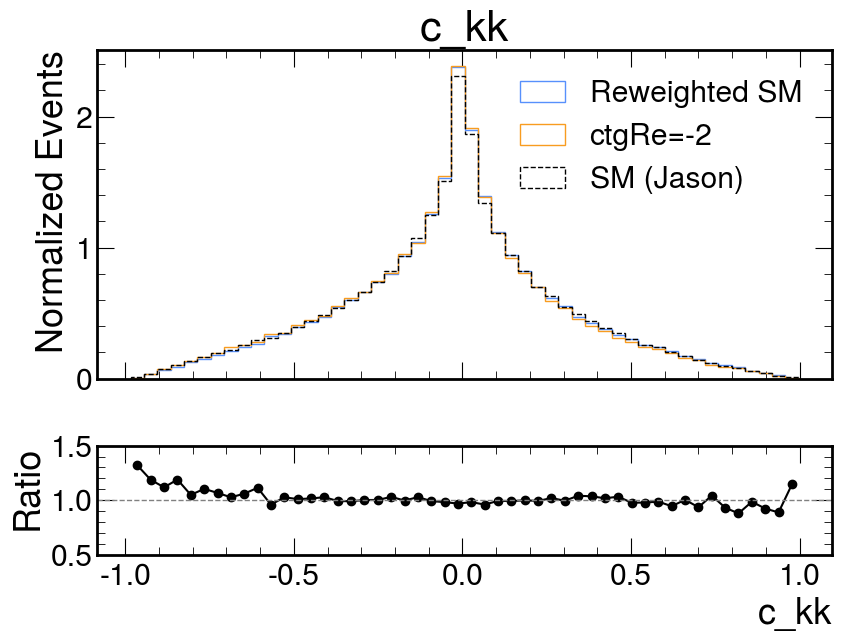

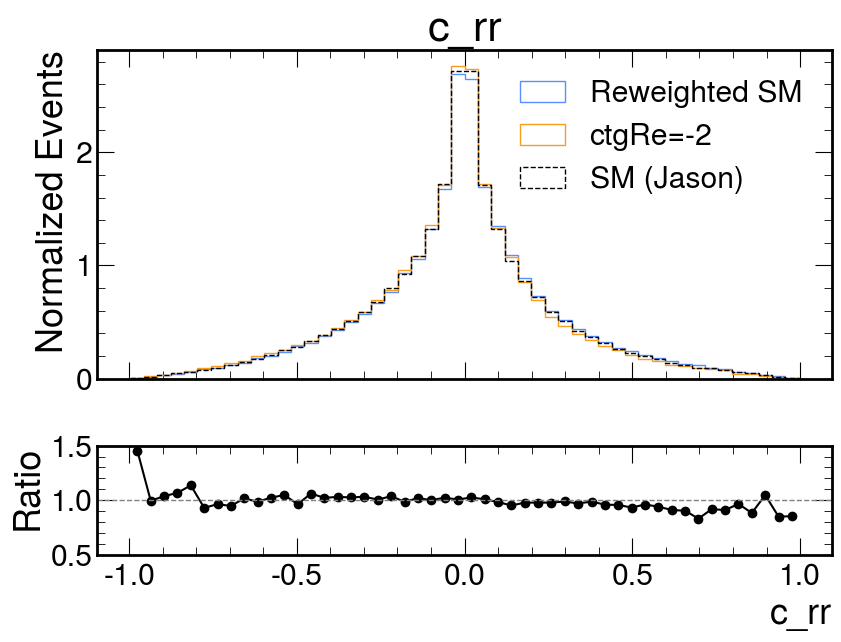

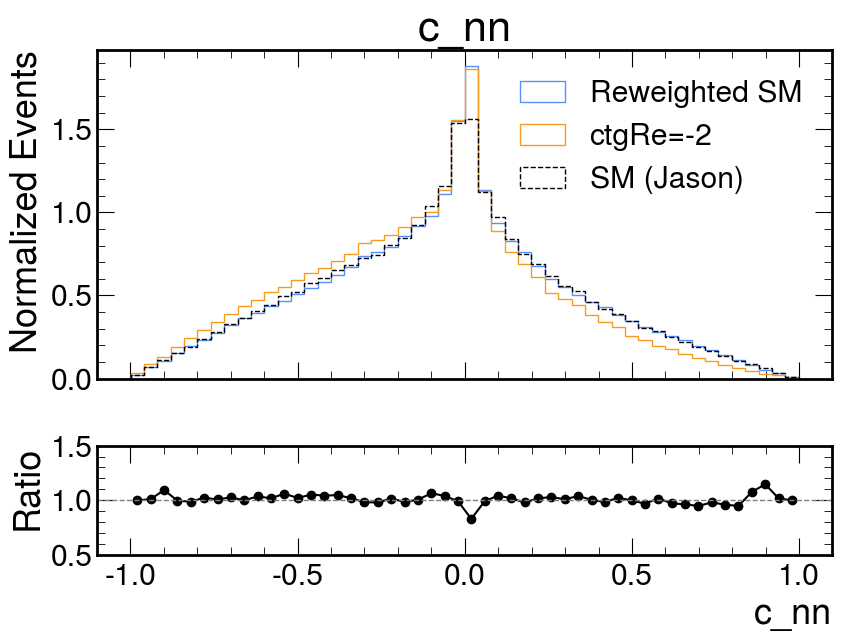

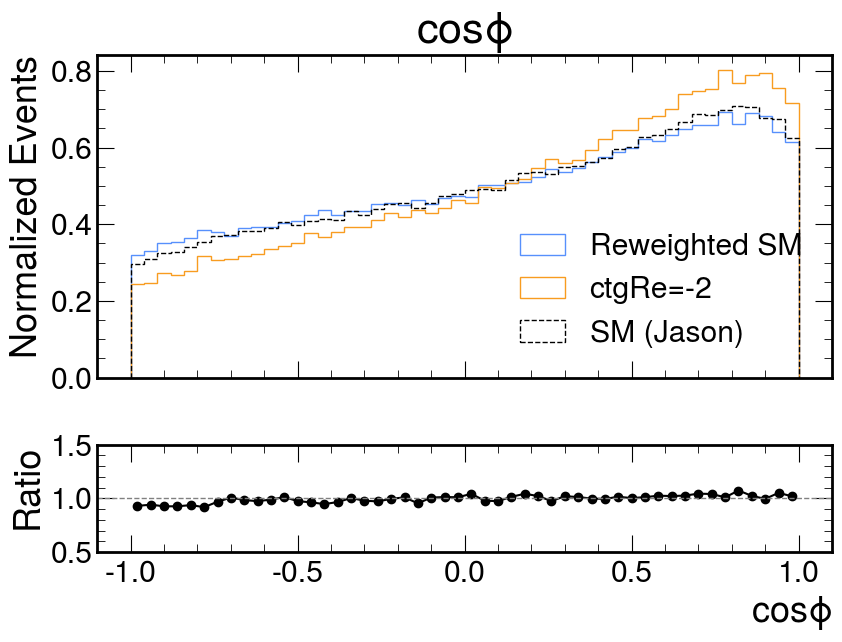

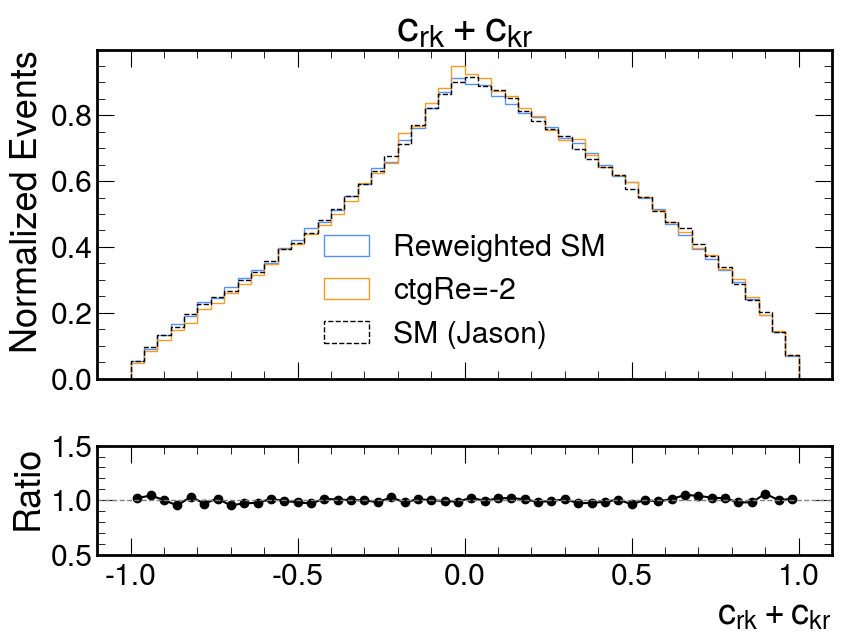

In [15]:
observables_reco = {
    
    'c_kk': file['c_kk'],
    'c_rr': file['c_rr'],
    'c_nn': file['gen_c_nn'],
    'll_cHel': file['ll_cHel'],
    'crk_ckr': file['c_rk'] + file['c_kr'],
}

observables_jason_reco = {
    'c_kk': file_jason['c_kk'],
    'c_rr': file_jason['c_rr'],
    'c_nn': file_jason['gen_c_nn'],
    'll_cHel': file_jason['ll_cHel'],
    'crk_ckr': file_jason['c_rk'] + file_jason['c_kr'],
}

# List of observables to plot
observables_to_plot_reco = {
    'c_kk': ('c_kk', 'c_kk'),
    'c_rr': ('c_rr', 'c_rr'),
    'c_nn': ('c_nn', 'c_nn'),
    'll_cHel': ('$cos\phi$', '$cos\phi$'),
    'crk_ckr': ('$c_{rk}+c_{kr}$', '$c_{rk}+c_{kr}$'),
}

# Loop through and plot all observables
for obs_key, (xlabel, title) in observables_to_plot_reco.items():
    plot_observables(observables_reco[obs_key], observables_jason_reco[obs_key], xlabel, title, weights_dict)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat
import Event_weight_prediction
import mplhep as hep
from uncertainties import unumpy as unp
plt.style.use(hep.style.CMS)

SC_saved = np.load('/depot/cms/top/bhanda25/EFT_minitree/Stored_SC/Stored_SC_541k.npy', allow_pickle=True)
mask_file = (file['gen_l_pt'] > 0) & (file['gen_lbar_pt'] > 0)
def assymetry(cosArr, weight, weight_sm):
    """Compute asymmetry A for a given observable array, using final weights."""
    weights=weight*weight_sm
    N1 = ufloat(np.sum(weights[cosArr > 0]), np.sqrt(np.sum(weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(weights[cosArr < 0]), np.sqrt(np.sum(weights[cosArr < 0]**2)))
    
    return (N1 - N2) / (N1 + N2)
    
def compute_deviations(wc_name, wc_range, observables, weights, weight_sm, SC_saved):
    """Generalized function to compute deviations for any Wilson Coefficient."""
    constant_factor_Cij = -4.0  
    constant_factor_CijCji = -16 / np.pi  
    constant_factor_D = -2
    deviations_dict = {}
    parameter_value = {}
    parameter_sm_value = {}
    Deviation_error={}
    for obs_name, obs_data in observables.items():
        deviations = []
        deviations_error = []
        
        # Assign appropriate constant factor
        if obs_name == "D":  # Check if the observable is cosphi (for D)
            constant_factor = constant_factor_D
        elif "+" in obs_name:
            constant_factor = constant_factor_CijCji
        else:
            constant_factor = constant_factor_Cij

        # Compute reference coefficient at weight_sm
        A_sm = assymetry(obs_data, weights, weight_sm)
        param_value_sm = constant_factor * A_sm
        parameter_sm_value[obs_name] = param_value_sm

        for wc_value in wc_range:
            wc_vector = [0] * 16  # Assume a 16-dimensional WC space
            wc_vector[3] = wc_value  # Modify only the relevant WC
            
            weight_wc, _, _ = Event_weight_prediction.event_weights_lin_quad(SC_saved, wc_vector)
            A_wc = assymetry(obs_data, weights, weight_wc[mask_file])
            param_value_wc = constant_factor * A_wc
            #parameters.append(param_value_wc)
            
            # Compute deviation from SM (keeps both central value and uncertainty)
            deviation = param_value_wc- param_value_sm  # This remains a `ufloat` object
            
            # Extract nominal value (central value) and standard deviation (error)
            deviations.append(deviation.nominal_value)
            deviations_error.append(deviation.std_dev)

            
        deviations_dict[obs_name] = deviations
        Deviation_error[obs_name]= deviations_error

    return  deviations_dict, Deviation_error

# Define the range of Wilson Coefficient values
wc_name =['ctGRe', 'ctGIm', 'cQj18', 'cQj38', 'cQj11', 'cQj31', 'ctu8', 'ctd8', 'ctj8', 'cQu8', 'cQd8', 'ctu1', 'ctd1', 'ctj1', 'cQu1', 'cQd1']   
wc_values = np.linspace(-3, 3, 21)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['gen_c_kk'][mask_file],
    r'$C_{nn}$': file['gen_c_nn'][mask_file],
    r'$C_{rr}$': file['gen_c_rr'][mask_file],
    r'D' : file['gen_ll_cHel'][mask_file],
    r'$C_{rk}+C_{kr}$': file['gen_c_rk'][mask_file] + file['gen_c_kr'][mask_file],
}

weight_sm=mg_weight[:,200][mask_file]
weights=file['trueLevelWeight'][mask_file]

# Compute deviations
deviations, Deviation_error= compute_deviations(wc_name[3], wc_values, observables, weights, weight_sm, SC_saved)



In [13]:
import numpy as np
from uncertainties import ufloat

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['c_kk'],
    r'$C_{nn}$': file['c_nn'],
    r'$C_{rr}$': file['c_rr']
}


# Define the constant multiplier
constant_factor = -4.0 

def assy(cosArr, weights, weight_sm):
    """Compute asymmetry A for a given observable array, applying SM reweighting."""
    total_weights = weights*weight_sm    # Apply SM reweighting
    
    N1 = ufloat(np.sum(total_weights[cosArr > 0]), np.sqrt(np.sum(total_weights[cosArr > 0]**2)))
    N2 = ufloat(np.sum(total_weights[cosArr < 0]), np.sqrt(np.sum(total_weights[cosArr < 0]**2)))
    
    return (N1 - N2) / (N1 + N2)

# Dictionary to store computed results
asymmetry_results = {}

# Compute asymmetry and parameter values for each observable
for obs_name, obs_data in observables.items():
    A = assy(obs_data, weights, weight_sm)  
    param_value = constant_factor * A  
    asymmetry_results[obs_name] = {'parameter value': param_value}

# Print results
for obs_name, values in asymmetry_results.items():
    print(f"{obs_name} = {values['parameter value'].nominal_value:.4f} ± {values['parameter value'].std_dev:.4f}")


$C_{kk}$ = 0.2306 ± 0.0098
$C_{nn}$ = 0.6948 ± 0.0097
$C_{rr}$ = 0.0813 ± 0.0098


In [296]:
# Define the range of Wilson coefficient ctGRe values
ctGRe_values = np.linspace(-0.5, 0.5, 9)

# Dictionary of observables
observables = {
    r'$C_{kk}$': file['gen_c_kk'],
    r'$C_{rr}$': file['gen_c_rr'],
    r'$C_{nn}$': file['gen_c_nn'],
    r'$C_{rk}+C_{kr}$': file['gen_c_rk'] + file['gen_c_kr'],
    r'$\frac{\Delta^{-}}{3}$': -(file['gen_c_kk'] + file['gen_c_rr'] + file['gen_c_nn'] + 1) / 3

}

# Dictionary to store mean cross-section differences for each observable
mean_xsec_differences_unbinned = {}

# Loop over each observable
for obs_name, observable_data in observables.items():
    sm_weight = np.array(weight_sm, dtype=np.float64)

    # Compute the unbinned mean for SM (weighted mean)
    mean_sm = 9*np.average(observable_data, weights=sm_weight)
    print(mean_sm)
    # Store mean differences for this observable
    mean_differences = []

    # Loop over ctGRe values
    for ctGRe in ctGRe_values:
        event_weights = np.array(predict_event_weight(ctGRe, 0), dtype=np.float64)

        # Compute unbinned weighted mean for ctGRe
        mean_ctGRe = 9*np.average(observable_data, weights=event_weights)
        print(mean_ctGRe)
        # Compute the difference
        diff = mean_ctGRe - mean_sm

        # Keep 5 decimal places
        mean_differences.append(diff)

    # Store results for this observable
    mean_xsec_differences_unbinned[obs_name] = mean_differences

-0.06296555074821278
-0.08462716317611144
-0.07961354465763902
-0.0742958684572025
-0.06872172909623996
-0.06296555074821289
-0.05713288174112226
-0.05136260017973519
-0.04582547072996145
-0.04071752762142951
0.050478736613134484
-0.06370438459956365
-0.03687609049724701
-0.008673801053081295
0.020595345480475823
0.0504787366131345
0.0803590838611282
0.10944792436646991
0.1367999728202564
0.16135580466232488
-0.46994058633460395
-0.6477507045797747
-0.6059136452483845
-0.56197069323688
-0.5164084335692223
-0.46994058633460417
-0.42353740160958275
-0.37843502258195033
-0.3361121413842497
-0.298222380204444
0.2617481158271499
0.26543463902782116
0.264567054485589
0.2636559115188257
0.2627113237577512
0.26174811582715
0.2607864312438844
0.2598519242355571
0.2589752727144927
0.25819077283103625
-2.8391908678461166
-2.7346392505237476
-2.759198907847563
-2.785019880406316
-2.811821728933978
-2.839190867846119
-2.8665629348464696
-2.8932167685513277
-2.918287454924674
-2.940805300307001


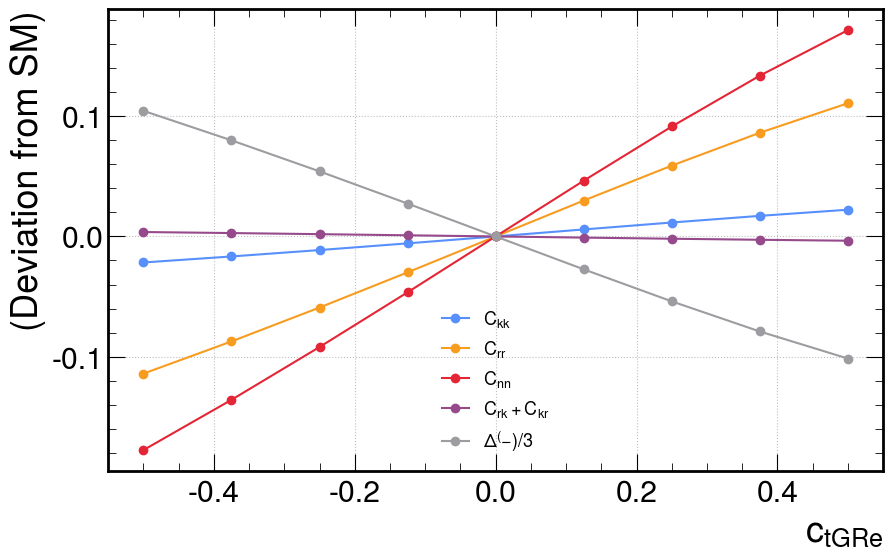

In [297]:
# Plot results
plt.figure(figsize=(10, 6))
for obs in observables:
    plt.plot(ctGRe_values, mean_xsec_differences_unbinned[obs], marker='o', linestyle='-', label=obs)

plt.xlabel(r"$c_{tGRe}$")
plt.ylabel(r"(Deviation from SM)")
#plt.title("Differential Cross-Section Deviation from SM")
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()

In [299]:
# Define the range of Wilson coefficient ctGRe values
ctGRe_values = np.linspace(-0.5, 0.5, 9)

# Dictionary of observables
observables_reco = {
    r'$C_{kk}$': file['c_kk'],
    r'$C_{rr}$': file['c_rr'],
    r'$C_{nn}$': file['c_nn'],
    r'$C_{rk}+C_{kr}$': file['c_rk'] + file['c_kr'],
    r'$\frac{\Delta^{-}}{3}$': -(file['c_kk'] + file['c_rr'] + file['c_nn'] + 1) / 3

}

# Dictionary to store mean cross-section differences for each observable
mean_xsec_differences_unbinned_reco = {}

# Loop over each observable
for obs_name, observable_data in observables_reco.items():
    sm_weight = np.array(weight_sm, dtype=np.float64)

    # Compute the unbinned mean for SM (weighted mean)
    mean_sm = 9*np.average(observable_data, weights=sm_weight)
    print(mean_sm)
    # Store mean differences for this observable
    mean_differences = []

    # Loop over ctGRe values
    for ctGRe in ctGRe_values:
        event_weights = np.array(predict_event_weight(ctGRe, 0), dtype=np.float64)

        # Compute unbinned weighted mean for ctGRe
        mean_ctGRe = 9*np.average(observable_data, weights=event_weights)
        print(mean_ctGRe)
        # Compute the difference
        diff = mean_ctGRe - mean_sm

        # Keep 5 decimal places
        mean_differences.append(diff)

    # Store results for this observable
    mean_xsec_differences_unbinned_reco[obs_name] = mean_differences

-0.20895543270469874
-0.24786565459737
-0.2387998033060688
-0.22922206620875227
-0.21922636775051096
-0.20895543270469885
-0.1986079853820292
-0.18844194298130953
-0.17877081235147493
-0.1699506344777837
-0.06797324338896095
-0.12267277638679146
-0.10982739941206565
-0.09631995635392726
-0.08229663471700194
-0.06797324338896099
-0.05364446911379207
-0.03968707590166939
-0.026553143302253016
-0.014749750388873648
-0.8196869049762122
-0.9575938551598018
-0.9251410122585888
-0.8910575125121624
-0.8557213941818341
-0.8196869049762125
-0.783707260634262
-0.7487418475824285
-0.7159380396153795
-0.6865786635067286
0.5096986826898747
0.534594444290921
0.5287351906576451
0.5225819489949365
0.5162030602772119
0.5096986826898753
0.5032048943197355
0.49689498473204197
0.4909761609851599
0.4856800505965718
-2.6344614731612257
-2.5572892381322383
-2.5754105951890294
-2.5944668218240663
-2.6142518679669857
-2.6344614731612266
-2.654680095142196
-2.674376378031394
-2.6929126684310205
-2.70957365073029

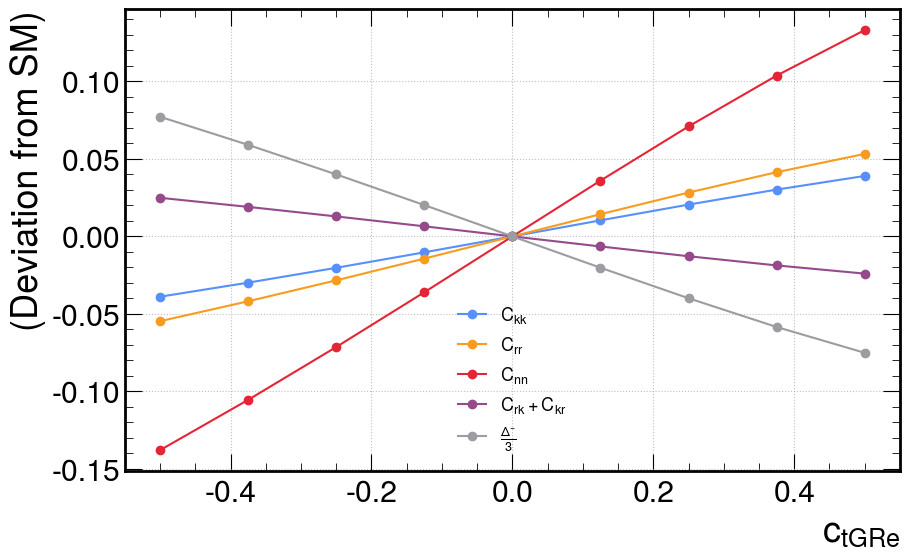

In [300]:
# Plot results
plt.figure(figsize=(10, 6))
for obs in observables_reco:
    plt.plot(ctGRe_values, mean_xsec_differences_unbinned_reco[obs], marker='o', linestyle='-', label=obs)

plt.xlabel(r"$c_{tGRe}$")
plt.ylabel(r"(Deviation from SM)")
#plt.title("Differential Cross-Section Deviation from SM")
plt.legend(loc='best', fontsize=13)
plt.grid()
plt.show()